In [1]:
#Template Project to build off of
import cv2 as cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import imageio
from tensorflow import keras
import os

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 64
EPOCHS = 20

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

LABELS = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
train_df = pd.read_csv("training_data.csv")
test_df = pd.read_csv("test_data.csv")

In [3]:
def crop_center(frame):
    y, x = frame.shape[0:2]
    min_dimension = min(y, x)
    start_x = x//2 - (min_dimension//2)
    start_y = y//2 - (min_dimension//2)
    return frame[start_y:start_y+min_dimension,start_x:start_x+min_dimension]

In [4]:
#From a video file (.mp4) extract every n-th frame and return them as a numpy array
#This will allow us to extract frames from a video and use them to train our model
#Every frame would be way too much data but we can test and hone in exactly how many 
#frames will be needed for a good model

def load_video(video_file, max_frames, resize=(IMG_SIZE, IMG_SIZE), n=1):
    #if the video file is an array , just return it
    if isinstance(video_file, list):
        frames = []
        for i, current_frame in enumerate(video_file):
            if i % n == 0:
                #frame = crop_center(frame)
                frame = cv2.resize(current_frame, resize)
                frame = frame[:, :, [2,1,0]]
                frames.append(frame)

            if len(current_frame) == max_frames:
                break
        return np.array(frames)
    #if video_file is a jpg file then return an array of 10 images in a numpy array
    if video_file.endswith(".jpg"):
        return np.array([np.array(cv2.resize(imageio.imread(video_file), resize)) for i in range(3)])

    video = cv2.VideoCapture(video_file)
    frames = []
    
    try:
        current_frame = 0
        while(True):
            ret,frame = video.read()
            if not ret:
                break
            if current_frame % n == 0:
               #frame = crop_center(frame)
                frame = cv2.resize(frame, resize)
                frame = frame[:, :, [2,1,0]]
                frames.append(frame)

            if len(frames) == max_frames:
                break
            current_frame += 1
    finally:
        video.release()
    return np.array(frames)

In [5]:
#A feature extractor will allow us to extarct only the most important parts
#of each frame and discard the rest. This will allow us to train our model
#faster and more efficiently
def create_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    pre_process_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    preprocessed = pre_process_input(inputs)
    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = create_feature_extractor()

In [6]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(LABELS)
)
print(label_processor.get_vocabulary())

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [8]:
# NEXT STEP: Create function using the above helper functions to load all the 
# video data that we plan to use, splitting them into training and validation sets
# along with their labels
# Then we can make a simple model to train on the data on, hopefully capable of 
# predicting the correct label for a given video (Fist or Hand)

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        #if the filename starts with an int then skip it
        if path[0].isdigit():
            continue
        
        if idx % 100 == 0:
            print(f"Processing video {idx} of {num_samples}.")
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path),20)
        #if the size of the frames is less than 2 then skip it
        if frames.shape[0] < 2:
            continue
        if frames.ndim != 4:
            print("Frames is not 4D")
            continue
        
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                ) 
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


#train_data, train_labels = prepare_all_videos(train_df, "train")
#test_data, test_labels = prepare_all_videos(test_df, "test")

train_data, train_labels = prepare_all_videos(train_df, "C:/Users/bencl/Desktop/data/Train")
test_data, test_labels = prepare_all_videos(test_df, "C:/Users/bencl/Desktop/data/Test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Processing video 0 of 9025.


C:\Users\bencl\AppData\Local\Temp/ipykernel_17128/3899283198.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return np.array([np.array(cv2.resize(imageio.imread(video_file), resize)) for i in range(3)])


Processing video 100 of 9025.
Processing video 200 of 9025.
Processing video 300 of 9025.
Processing video 400 of 9025.
Processing video 500 of 9025.
Processing video 600 of 9025.
Processing video 700 of 9025.
Processing video 800 of 9025.
Processing video 900 of 9025.
Processing video 1000 of 9025.
Processing video 1100 of 9025.
Processing video 1200 of 9025.
Processing video 1300 of 9025.
Processing video 1400 of 9025.
Processing video 1500 of 9025.
Processing video 1600 of 9025.
Processing video 1700 of 9025.
Processing video 1800 of 9025.
Processing video 1900 of 9025.
Processing video 2000 of 9025.
Processing video 2100 of 9025.
Processing video 2200 of 9025.
Processing video 2300 of 9025.
Processing video 2400 of 9025.
Processing video 2500 of 9025.
Processing video 2600 of 9025.
Processing video 2700 of 9025.
Processing video 2800 of 9025.
Processing video 2900 of 9025.
Processing video 3000 of 9025.
Processing video 3100 of 9025.
Processing video 3200 of 9025.
Processing video 

In [7]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    x = keras.layers.Dropout(0.1)(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

Epoch 1/200
226/226 [==============================] - 18s 50ms/step - loss: 3.1265 - accuracy: 0.0846 - val_loss: 2.9293 - val_accuracy: 0.1612

Epoch 00001: val_accuracy improved from -inf to 0.16122, saving model to tmp\video_classifier
Epoch 2/200
226/226 [==============================] - 8s 37ms/step - loss: 2.8016 - accuracy: 0.1428 - val_loss: 2.6326 - val_accuracy: 0.2321

Epoch 00002: val_accuracy improved from 0.16122 to 0.23213, saving model to tmp\video_classifier
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.5072 - accuracy: 0.2166 - val_loss: 2.2285 - val_accuracy: 0.2975

Epoch 00003: val_accuracy improved from 0.23213 to 0.29751, saving model to tmp\video_classifier
Epoch 4/200
226/226 [==============================] - 9s 40ms/step - loss: 2.3161 - accuracy: 0.2568 - val_loss: 2.0244 - val_accuracy: 0.4000

Epoch 00004: val_accuracy improved from 0.29751 to 0.40000, saving model to tmp\video_classifier
Epoch 5/200
226/226 [=============

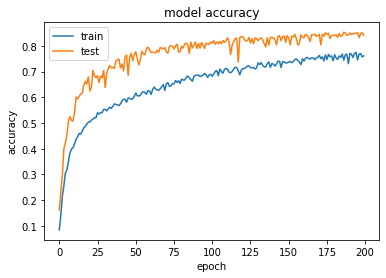

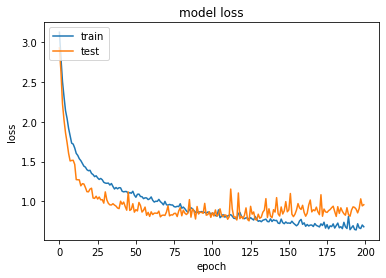

5/5 [==============================] - 0s 19ms/step - loss: 0.9920 - accuracy: 0.8062
Test accuracy: 80.62%


In [73]:
from matplotlib import pyplot as plt
# Utility for running experiments.
def run_experiment():
    filepath = "tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_best_only=True, save_weights_only=True, verbose=1, monitor="val_accuracy"
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.20,
        epochs=200,
        callbacks=[checkpoint],
    )

    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

In [8]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path),20)
    frame_features, frame_mask = prepare_single_video(frames)

    #if dequence model has been trained then use it otherwise load model
    try:
        model = sequence_model
    except NameError:
        model = get_sequence_model()
        model.load_weights("tmp/video_classifier")
        
    probabilities = model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


In [9]:
test_dir = "C:/Users/bencl/Desktop/data/Test/"

test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_dir + test_video}")
test_frames = sequence_prediction(test_dir + test_video)
#to_gif(test_frames[:MAX_SEQ_LENGTH])

Test video path: C:/Users/bencl/Desktop/data/Test/R195.jpg


C:\Users\bencl\AppData\Local\Temp/ipykernel_12120/3488690343.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return np.array([np.array(cv2.resize(imageio.imread(video_file), resize)) for i in range(3)])


  X: 59.70%
  R: 33.44%
  D:  3.29%
  I:  1.42%
  V:  0.86%
  O:  0.53%
  K:  0.37%
  F:  0.19%
  Q:  0.16%
  C:  0.01%
  E:  0.01%
  L:  0.00%
  S:  0.00%
  U:  0.00%
  N:  0.00%
  G:  0.00%
  W:  0.00%
  B:  0.00%
  Y:  0.00%
  M:  0.00%
  J:  0.00%
  Z:  0.00%
  P:  0.00%
  H:  0.00%
  T:  0.00%
  A:  0.00%


In [10]:
#get live feed from web cam and predict the action given last 10 frames
import cv2
def predict_signs():
    try:
        model = sequence_model
    except NameError:
        model = get_sequence_model()
        model.load_weights("tmp/video_classifier")
        
    current_frames = []
    cap = cv2.VideoCapture(0)
    #check if opened correctly
    while cap.isOpened():
        flags, frame = cap.read()
        if not flags:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        cv2.imshow('img', frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        current_frames.append(frame)
        if len(current_frames) == 10:
            #turn frames into video with cv2 
            frame_features, frame_mask = prepare_single_video(load_video(current_frames, 20))
            probabilities = model.predict([frame_features, frame_mask])[0]
            class_vocab = label_processor.get_vocabulary()
            for i in np.argsort(probabilities)[::-1]:
                print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
                if i == 0:
                    break
            current_frames = []
    cap.release()
    cv2.destroyAllWindows() 

predict_signs()

  M: 99.61%
  A:  0.37%
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). E

: 

: 